In [1]:
%matplotlib ipympl
import time
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev

In [2]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [3]:
def get_normalized_transmission(data_number):
    data, header = get_experiment_data(data_number)
    detunings_MHz = header["detunings"].to("MHz").magnitude
    transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], header["params"]["detect"]["cycles"], return_err=True)
    monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], header["params"]["detect"]["cycles"], return_err=True)
    normalized_avg = {}
    for kk in transmissions_avg:
        if transmissions_avg[kk].ndim >= 1:
            normalized_avg[kk] = unumpy.uarray(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
        else:
            normalized_avg[kk] = ufloat(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
    return detunings_MHz, normalized_avg, header

In [4]:
def get_experiment_result(data_number):
    detunings, data, header = get_normalized_transmission(data_number)
    total_pop_1 = data["1"] - data["2"]
    pop_other_state_1 = data["1"] - data["3"]
    total_pop_2 = data["4"] - data["5"]
    pop_other_state_2 = data["4"] - data["6"]
    # print(total_pop_1, total_pop_2)
    return (header, pop_other_state_1 + pop_other_state_2, total_pop_1 + total_pop_2)

In [5]:
def get_results(data_identification):
    data_list = data_identification_to_list(data_identification)
    headers = []
    results = []
    for data_number in data_list:
        header, pop_other_state, total_pop = get_experiment_result(data_number)
        headers.append(header)
        results.append(pop_other_state / total_pop)
    return headers, np.array(results)

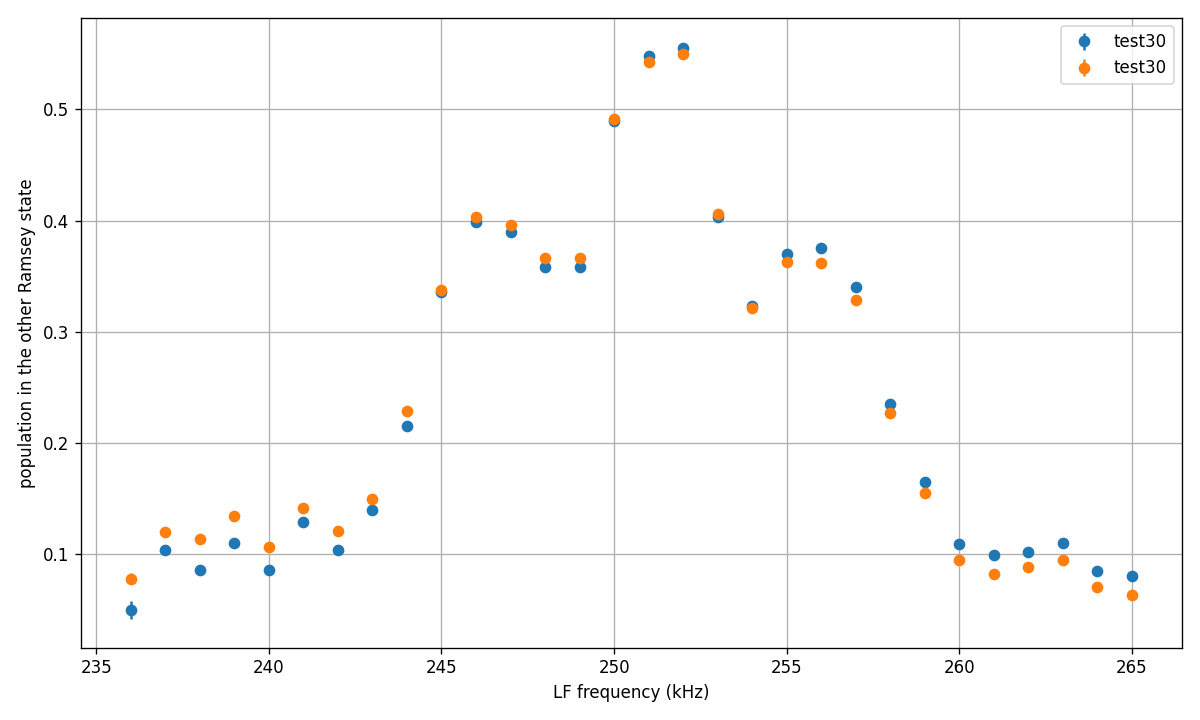

In [6]:
data = {
    "test30": (978080, 978109),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results = get_results(data_range)
    xs = [(header["params"]["lf"]["detunings"][0] + header["params"]["lf"]["center_frequencies"][0]).to("kHz").magnitude for header in headers]
    if results.ndim == 1:
        ys = unumpy.nominal_values(results)
        errs = unumpy.std_devs(results)
        ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')
    else:
        for kk in range(2):
            ys = unumpy.nominal_values(results[:, kk])
            errs = unumpy.std_devs(results[:, kk])
            ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel(f"LF frequency (kHz)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

ValueError: 'yerr' (shape: (30, 1)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (30, 1))

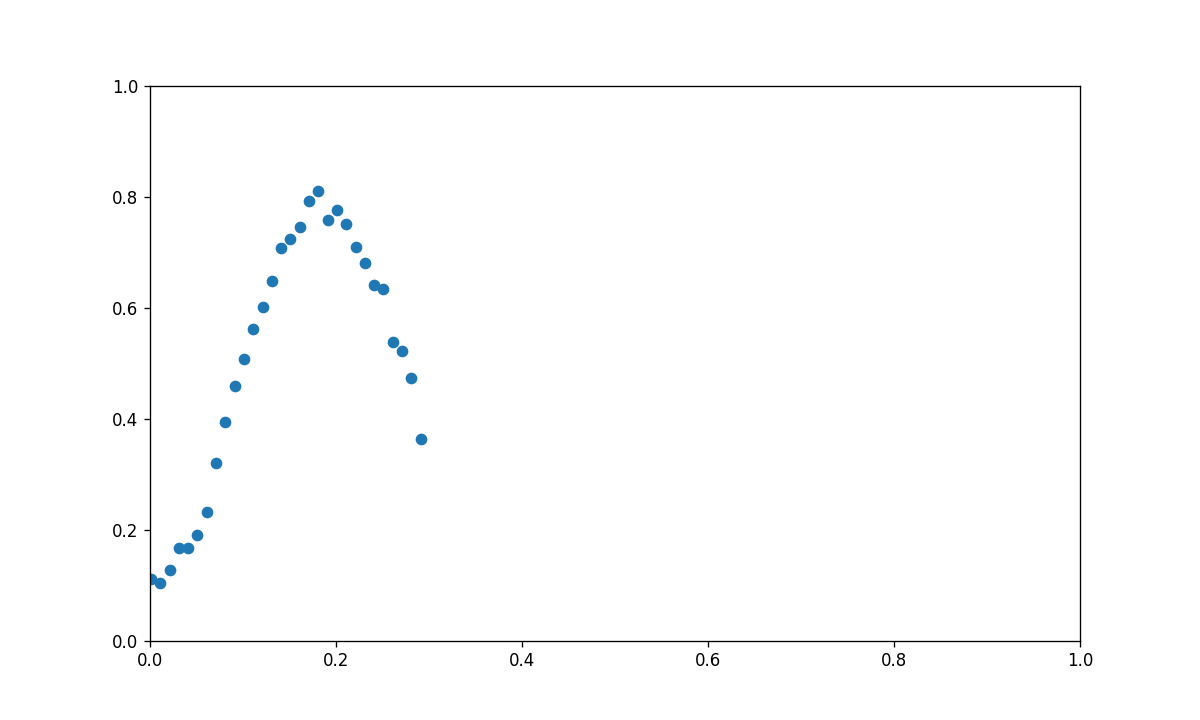

In [7]:
data = {
    "a-abar, 8000": (976951, 976980),
    "a-abar, 8000, more detects": (976981, 977010),
    "a-abar, 8000, less detects": (977011, 977040),
}

fig, ax = plt.subplots(figsize = (10, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    headers, results = get_results(data_range)
    xs = [header["params"]["lf"]["duration"].to("ms").magnitude for header in headers]
    ys = unumpy.nominal_values(results)
    errs = unumpy.std_devs(results)
    ax.errorbar(xs, ys, errs, label=label, marker='o', linestyle='')

ax.set_xlabel(f"LF duration (ms)")
ax.set_ylabel("population in the other Ramsey state")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

## long term

In [8]:
def get_lt_experiment_result(data_identification):
    data_list = data_identification_to_list(data_identification)
    slope = 1e-4
    min_detuning = (251.3 - 1.5) * 1e3
    detuning_diff = 3e3
    field_plates = []
    times = []
    f_p = []
    f_m = []
    for data_number in data_list:
        detunings, data, header = get_normalized_transmission(data_number)
        for kk, field_plate in enumerate([False, True, True, False]):
            for ll, lf_order in enumerate([False, True]):
                y0 = 0
                y1 = 0
                if lf_order:
                    lf_indices = [0, 1]
                else:
                    lf_indices = [1, 0]
                for mm, lf_index in enumerate(lf_indices):
                    detect_index_group = kk * 4 + ll * 2 + mm
                    total_pop_1 = data[str(detect_index_group * 6 + 1)] - data[str(detect_index_group * 6 + 2)]
                    pop_other_state_1 = data[str(detect_index_group * 6 + 1)] - data[str(detect_index_group * 6 + 3)]
                    total_pop_2 = data[str(detect_index_group * 6 + 4)] - data[str(detect_index_group * 6 + 5)]
                    pop_other_state_2 = data[str(detect_index_group * 6 + 5)] - data[str(detect_index_group * 6 + 6)]
                    results = (pop_other_state_1 + pop_other_state_2) / (total_pop_1 + total_pop_2)
                    if lf_index == 0:
                        y0 = results
                    else:
                        y1 = results
                #print(lf_order, y1 - y0)
                delta_y_sum = detuning_diff * slope
                delta_y_red = (delta_y_sum - (y0 - y1)) / 2
                freq_center = detuning_diff / delta_y_sum * delta_y_red + min_detuning
                field_plates.append(field_plate)
                if field_plate:
                    f_p.append(freq_center[1])
                    f_m.append(freq_center[0])
                else:
                    f_p.append(freq_center[0])
                    f_m.append(freq_center[1])
                times.append(header["data_info"]["save_epoch_time"])
    return np.array(times), np.array(field_plates), np.array(f_p), np.array(f_m)

In [9]:
# (978245, 978245 + 372) heating problem

In [10]:
times, field_plates, f_p, f_m = get_lt_experiment_result((978638, 978638 + 5740))

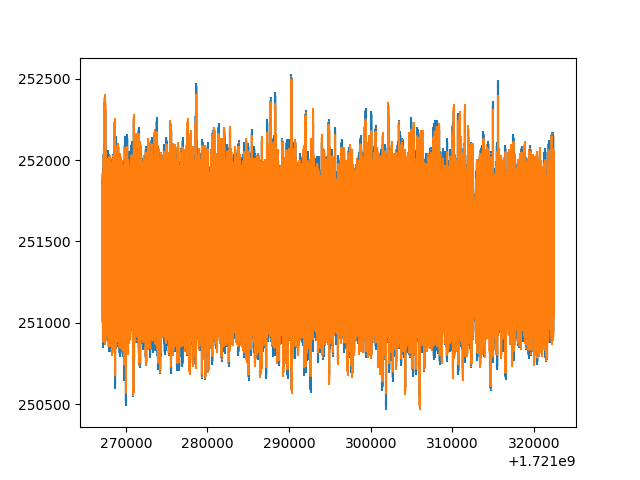

In [11]:
fig, ax = plt.subplots()
ax.errorbar(times, unumpy.nominal_values(f_p), unumpy.std_devs(f_p))
ax.errorbar(times, unumpy.nominal_values(f_m), unumpy.std_devs(f_m))
plt.show()

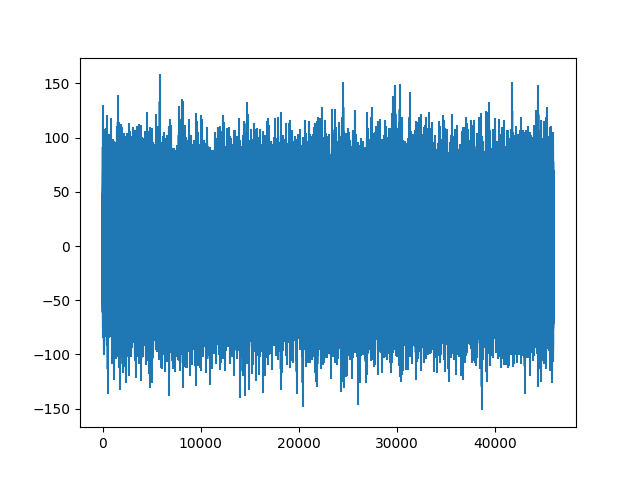

In [12]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(len(f_p)), unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m), unumpy.std_devs(f_p))
plt.show()

In [16]:
W_T = ufloat(
    np.average(unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m)),
    np.std(unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m)) / np.sqrt(len(f_p))
)
print(W_T)

0.23+/-0.15


In [17]:
W_T_E_p1 = ufloat(
    np.average((unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m))[field_plates]),
    np.std((unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m))[field_plates]) / np.sqrt(len(f_p[field_plates]))
)
print(W_T_E_p1)

-2.13+/-0.21


In [18]:
W_T_E_m1 = ufloat(
    np.average((unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m))[~field_plates]),
    np.std((unumpy.nominal_values(f_p) - unumpy.nominal_values(f_m))[~field_plates]) / np.sqrt(len(f_p[~field_plates]))
)
print(W_T_E_m1)

2.60+/-0.21
